# **Criando um Sistema de Reconhecimento Facial do Zero**

Este projeto tem o objetivo de trabalhar com as bibliotecas e frameworks estudados e analisados em aula para a elaboração de um sistema de detecção e reconhecimento de faces.

## **Passo 1**
Fazer a importação das Bibliotecas necessárias.

In [1]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython import get_ipython
from IPython.display import display
from base64 import b64decode

## **Passo 2**
Criar função para capturar fotos usando a câmera do dispositivo, utilizando o módulo *Javascript* do *IPython* para integrar código JavaScript ao ambiente de execução e captura uma foto por meio da câmera do usuário.

In [2]:
def capturar_foto(nome_arquivo='imagem.jpg', qualidade=0.9):
    js = Javascript('''
        async function capturarFoto(qualidade) {
            const container = document.createElement('div');
            const botao = document.createElement('button');
            botao.textContent = 'Tirar Foto';
            container.appendChild(botao);

            const videoFeed = document.createElement('video');
            videoFeed.style.display = 'block';
            const fluxo = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(container);
            container.appendChild(videoFeed);
            videoFeed.srcObject = fluxo;
            await videoFeed.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolver) => botao.onclick = resolver);

            const canvas = document.createElement('canvas');
            canvas.width = videoFeed.videoWidth;
            canvas.height = videoFeed.videoHeight;
            canvas.getContext('2d').drawImage(videoFeed, 0, 0);
            fluxo.getVideoTracks()[0].stop();
            container.remove();
            return canvas.toDataURL('image/jpeg', qualidade);
        }
    ''')
    display(js)
    dados = eval_js('capturarFoto({})'.format(qualidade))
    binario = b64decode(dados.split(',')[1])
    with open(nome_arquivo, 'wb') as arquivo:
        arquivo.write(binario)
    return nome_arquivo

In [4]:
image_file = capturar_foto()

<IPython.core.display.Javascript object>

Exibindo a imagem tirada.

400 533


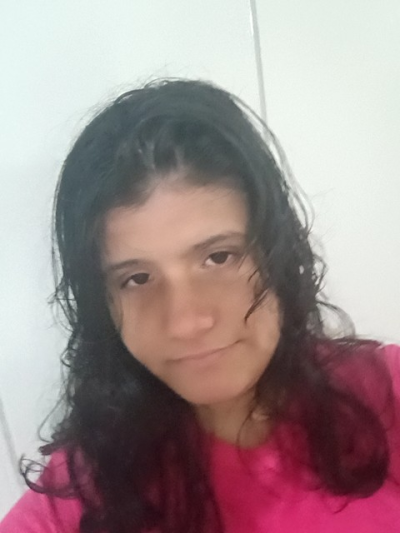

In [5]:
imagem = cv2.imread(image_file)

# redimensiona para ter uma largura máxima de 400 pixels
imagem = imutils.resize(imagem, width=400)
(h, w) = imagem.shape[:2]
print(w,h)
cv2_imshow(imagem)


## **Passo 3**

Baixando arquivos necessários para realizar detecção de faces utilizando OpenCV. Os arquivos são:

- **deploy.prototxt:** Define a arquitetura da rede neural, incluindo as camadas e conexões.
- **res10_300x300_ssd_iter_140000.caffemodel:** Contém os pesos do modelo treinado para detectar faces.

In [6]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-01-01 01:47:04--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2025-01-01 01:47:04 (12.5 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2025-01-01 01:47:04--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Carregando o modelo de detecção facial pré-treinado do disco e redimensionando a imagem.

In [7]:
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

# Redimensiona a imagem para ter uma largura de 400 pixels
imagem = imutils.resize(imagem, width=400)

# Prepara o blob para ser usado no modelo
blob = cv2.dnn.blobFromImage(cv2.resize(imagem, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

## **Passo 4**
Realizando a detecção de faces utilizando uma rede neural previamente carregada.

- **net.setInput(blob):** Define o blob pré-processado como a entrada da rede neural.
Execução da detecção:

- **net.forward():** Realiza a passagem para frente (forward pass) na rede neural, retornando as detecções como um conjunto de resultados.

In [8]:
net.setInput(blob)
detections = net.forward()

## **Passo 5**
Percorrendo os resultados da detecção e desenhando caixas delimitadoras (bounding boxes) ao redor das faces detectadas na imagem, exibindo também a confiança da detecção em porcentagem.

In [9]:
for i in range(0, detections.shape[2]):

    # extrair a probabilidade associada à previsão
    confidence = detections[0, 0, i, 2]

    if confidence > 0.7: #Mínimo de 70% de certeza
        # calcula as coordenadas (x, y) da caixa delimitadora do objeto
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # desenha a caixa delimitadora da face e a probabilidade
        porcentagem = "{:.2f}%".format(confidence * 100)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(imagem, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(imagem, porcentagem, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

🌟 Resultado final...

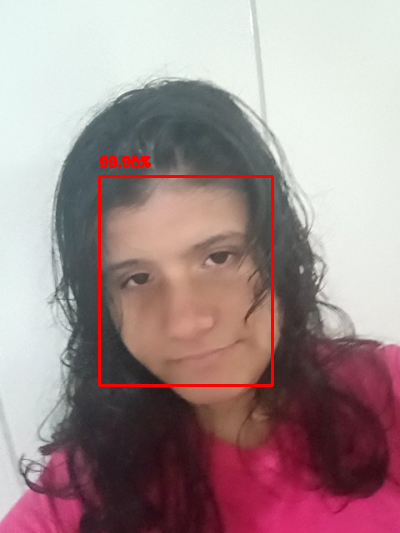

In [10]:
cv2_imshow(imagem)